In [70]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

df = pd.read_csv("zitbanken0.csv", sep=";")
print(df.head())

   OBJECTID     ID      STADSDEEL  BUURT_CODE                    STRAAT  \
0      1144  10616         Gestel        1713  Maria van Bourgondiëlaan   
1      1146  10619       Tongelre        1335       Keizersmantelstraat   
2      1148  13192         Gestel        1726                       NaN   
3      1154  13274         Gestel        1711           Scheidingstraat   
4      1156  12956  Park Meerland        1640                Waterfront   

      EIGENAAR      BEHEERDER    ONDERHOUDER            SOORT   VOET  \
0          BOR  BOR Stedelijk  BOR Stedelijk          Zitbank  Beton   
1          BOR  BOR Stedelijk  BOR Stedelijk      Picknickset  Beton   
2  Particulier    Particulier    Particulier              NaN    NaN   
3          BOR  BOR Stedelijk  BOR Stedelijk  Model Eindhoven  Beton   
4          BOR  BOR Stedelijk  BOR Stedelijk      Flyer Eagle  Staal   

   ZITOBJECT    AFWERKING         KLEUR  AANLEG_JAAR STANDPLAATS LOCATIE  \
0  Kunststof          Lak         Groen 

Which coordinate system is this most likely to be in dataset?

In [ ]:
# Are values around 51 / 5 typical for the Netherlands? Yes.
#
# There is only one answer that fits the scale and format:
#
# A. EPSG:4326 (WGS84 latitude/longitude)

In [20]:
# To do real spatial analysis, you need to:

# Split the string into numeric lat/lon

df[["lat", "lon"]] = df["geo_point_2d"].str.split(",", expand=True)

df["lat"] = df["lat"].astype(float)
df["lon"] = df["lon"].astype(float)


## Convert the DataFrame to a GeoDataFrame

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]))

    # Why do we use points_from_xy(df["lon"], df["lat"]) instead of lat/lon reversed?
    # The correct order for geometry construction is:
    # (lon, lat) → X, Y
    # Why?
    # Longitude = X-axis (horizontal)
    # Latitude = Y-axis (vertical)

# Set the CRS to EPSG:4326

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326")

# Project it into a metric CRS (for distances & clustering), typically EPSG:28992 (Dutch RD New)

gdf_28992 = gdf.to_crs("EPSG:28992")

    # Why?
    # Because you cannot compute distances, clusters, densities, or spatial relationships in degrees.
    # You need a CRS measured in meters.
    # For the Netherlands, the correct projection is:
    # EPSG:28992 — Amersfoort / RD New
    # This is the Dutch national grid.

# DBSCAN Spatial Clustering

In [ ]:
# Now we move to an advanced technique that reveals how benches are distributed spatially:

    # DBSCAN is perfect here because:
        # it identifies dense clusters automatically
        # it handles irregular shapes (parks, squares)
        # it detects noise/outliers
        # it doesn’t force you to choose a fixed number of clusters

QUESTION: Choosing DBSCAN Parameters


In [42]:
# DBSCAN requires two parameters:
    # eps — the neighborhood radius
        # measured in meters because you projected to EPSG:28992
        # typical values for human-scale urban clustering: 200m - 300 m. but we consider here 50 meters because it can capture broader park zones.

    # min_samples — minimum points needed to form a cluster
        # often between 5–20 for urban object clustering. For 2-dimensional urban data (latitude and longitude), the recommended default value is 4. here we take 10.

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=100, min_samples=7)

# build the feature matrix: creates a NumPy aaray with coordinates:

coords = np.vstack([gdf_28992.geometry.x, gdf_28992.geometry.y]).T

# Run DBSCAN on the coordinates

labels = db.fit_predict(coords)

#print(labels)
#print("That means: \nCluster IDs go from 0 to 19 → 20. \nClusters-1 values → benches considered noise/outliers")


Cluster number: 133
Noise number: 1637
INTERPRETATION: 
 What this actually means: 
 eps=80 is large enough to catch some spatial groupings but still too small for many park layouts, so DBSCAN only detects tight seating pockets, not full park structures and still considers ~61% of benches as noise.

 Bench spacing in Eindhoven’s parks is more dispersed than I assumed. They’re not placed in clusters of 10 benches within 80 meters. They’re spread across large areas.


Your next task: count clusters + noise

In [44]:
n_clusters = len(set(labels) - {-1})
n_noise = np.sum(labels == -1)
print("Cluster number:", n_clusters)
print("Noise number:", n_noise)

print("INTERPRETATION: \n What this actually means: \n With a 100-meter radius, DBSCAN is detecting seating pockets inside parks and squares. You now have 133 distinct seating areas across Eindhoven. Noise dropped drastically compared to eps=80. But ~1637 benches (about 40%) are still too isolated to form clusters of 7 nearby benches — which makes sense for scattered benches along paths.\n\n Bench spacing in Eindhoven’s parks is more dispersed than I assumed. They’re not placed in clusters of 10 benches within 80 meters. They’re spread across large areas.")

Cluster number: 133
Noise number: 1637
INTERPRETATION: 
 What this actually means: 
 With a 100-meter radius, DBSCAN is detecting seating pockets inside parks and squares. You now have 133 distinct seating areas across Eindhoven. Noise dropped drastically compared to eps=80. But ~1637 benches (about 40%) are still too isolated to form clusters of 7 nearby benches — which makes sense for scattered benches along paths.

 Bench spacing in Eindhoven’s parks is more dispersed than I assumed. They’re not placed in clusters of 10 benches within 80 meters. They’re spread across large areas.


NEXT STEP: Attach the cluster labels to the GeoDataFrame

In [54]:
# This will allow you to:

    # map clusters
    # analyze cluster sizes
    # compare parks vs. clusters
    # characterize each cluster
    # detect outliers
    # find underserved areas

gdf_28992["cluster"] = labels

# Count benches per cluster

cluster_size = gdf_28992[gdf_28992["cluster"] != -1]["cluster"].value_counts()
print(cluster_size.describe())

print("\n\nINTERPRETATION:\nMost seating areas are small (8–11 benches) \nA few seating areas are large (20+ benches) \nOne enormous cluster has 144 benches → that’s a major park or large public space \nThe clusters vary widely (std ≈ 18.5) min = 4 benches → your min_samples=7 is insufficiently enforced")

count    133.000000
mean      18.285714
std       18.545020
min        4.000000
25%        8.000000
50%       11.000000
75%       21.000000
max      144.000000
Name: count, dtype: float64


INTERPRETATION:
Most seating areas are small (8–11 benches) 
A few seating areas are large (20+ benches) 
One enormous cluster has 144 benches → that’s a major park or large public space 
The clusters vary widely (std ≈ 18.5) min = 4 benches → your min_samples=7 is insufficiently enforced


What does a 144-bench cluster reveal about Eindhoven’s strategy for structuring public life?

In [ ]:
# A 144-bench cluster means:

# The city created a large, centralized social space
# It is intentionally equipped for high-volume, prolonged gathering
# It functions differently from smaller parks or pathways
# It is a primary public node, not a neighborhood amenity

Assign a “cluster type” based on LOCATIE

In [64]:
def safe_mode(series):
    m = series.mode()
    return m.iloc[0] if len(m) > 0 else "Unknown"


cluster_types = (
    gdf_28992[gdf_28992["cluster"] != -1]
    .groupby("cluster")["LOCATIE"]
    .agg(safe_mode)
)

print(cluster_types.head(20))

print("\n\nINTERPRETATION \nBenches are spatially arranged in park-like cluster formations — and DBSCAN detects them purely from coordinate geometry.")

TypeError: no numeric data to plot

You need to quantify how many clusters belong to each location type, including “Unknown”.

In [62]:
cluster_type_counts = cluster_types.value_counts()
print(cluster_type_counts)

print("\n\nINTERPRETATION: \n73 park clusters → parks dominate seating structure\n22 square (plein) clusters → public squares are the second-most structured spaces \n“Unknown” clusters (18) → these are clusters whose benches had missing or unreliable LOCATIE values\nOverig: 13 → mixed-use or undefined urban spaces\nShops (Winkel): 4 → small commercial seating zones\nSchools: 2 → minimal school clusters\nAbri: 1 → one bus-stop seating cluster")

LOCATIE
Park       73
Plein      22
Unknown    18
Overig     13
Winkel      4
School      2
Abri        1
Name: count, dtype: int64


INTERPRETATION: 
73 park clusters → parks dominate seating structure
22 square (plein) clusters → public squares are the second-most structured spaces 
“Unknown” clusters (18) → these are clusters whose benches had missing or unreliable LOCATIE values
Overig: 13 → mixed-use or undefined urban spaces
Shops (Winkel): 4 → small commercial seating zones
Schools: 2 → minimal school clusters
Abri: 1 → one bus-stop seating cluster


In [ ]:
Code to Visualize DBSCAN Clusters in Python (GeoPandas + Matplotlib)

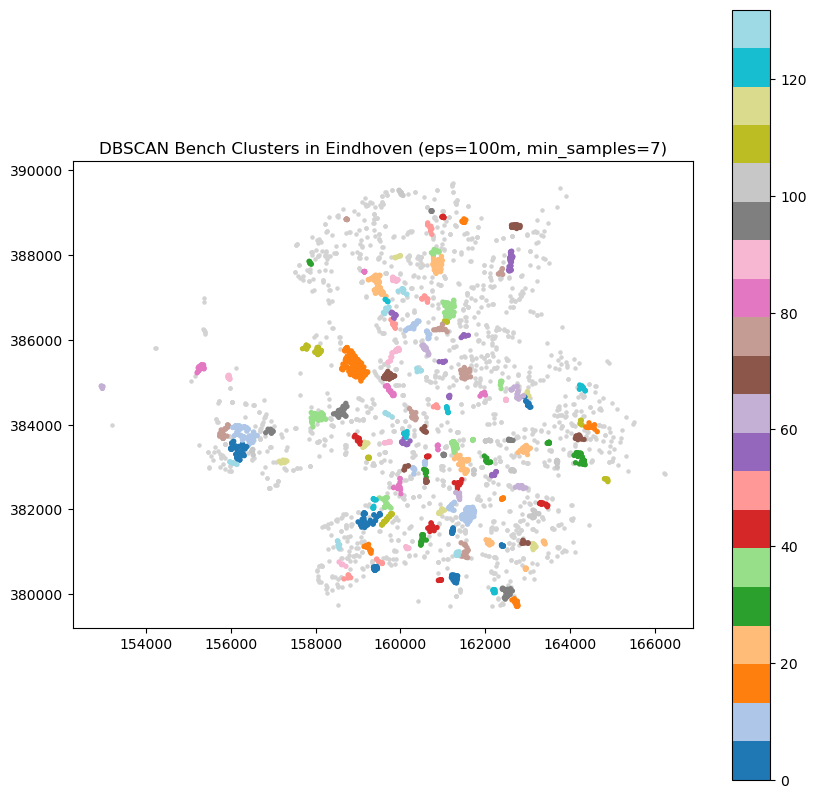

INTERPRETATION:

Noise (non-cluster points) as light gray
Each cluster in different color
A map scaled correctly
Proper geographic spacing according to EPSG:28992


In [67]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot noise points in light gray
gdf_28992[gdf_28992["cluster"] == -1].plot(
    ax=ax,
    markersize=5,
    color="lightgray",
    label="Noise"
)

# Plot clusters, each with different color
gdf_28992[gdf_28992["cluster"] != -1].plot(
    ax=ax,
    column="cluster",
    cmap="tab20",
    markersize=8,
    legend=True,
    label="Clusters"
)

plt.title("DBSCAN Bench Clusters in Eindhoven (eps=100m, min_samples=7)")
plt.show()

print("INTERPRETATION:\n\nNoise (non-cluster points) as light gray\nEach cluster in different color\nA map scaled correctly\nProper geographic spacing according to EPSG:28992")

3. OPTIONAL (Recommended): Plot on a Basemap

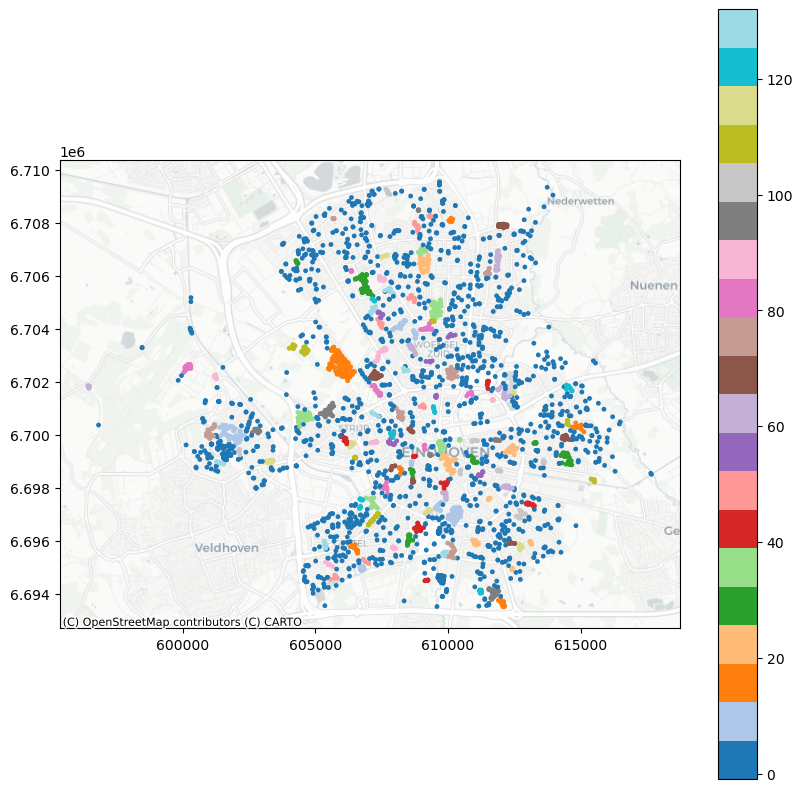

In [71]:
gdf_28992.to_crs(epsg=3857).plot(
    column="cluster",
    cmap="tab20",
    markersize=6,
    figsize=(10, 10),
    legend=True
)

ctx.add_basemap(plt.gca(), source=ctx.providers.CartoDB.Positron)
plt.show()